# 决策树（ID3）

    优点：计算复杂度不高，输出结果易于理解，对中间值缺失不敏感，可以处理不相关特征数据
    缺点：可能会产生过度匹配的问题
    适用数据类型：数值型和标称型
    

                                    决策树的一般流程
    （1）收集数据：可以使用任何方法
    （2）准备数据：树构造算法只适用于标称型数据，因此数值型数据必须离散化
    （3）分析数据：可以使用任何方法，树构造完成之后，我们应该检查图形是否符合预期
    （4）训练算法：构造树的数据结构
    （5）测试算法：使用经验树计算错误率
    （6）使用算法：此步骤可以适用任何监督学习算法，而使用决策树可以更好地理解数据的内在含义

2.1 计算给的数据集的香农熵


信息增益  [信息增益是熵的减少或数据无序度的减少]:

    1.划分数据集的大原则是：将无序的数据变得更加有序
    2.在划分数据集之前之后信息发生的变化称为信息增益(之前的信息熵-之后的信息熵)。
    3.知道如何计算信息增益，我们就可以计算每个特征值划分数据集获得的信息增益，获得信息增益最高的特征就是最好的选择。
    4.集合信息的度量方式称为香农熵或者简称为熵（熵定义为信息的期望值）
    5.为了计算熵，我们需要计算所有类别所有可能值包含的信息期望值：H = -np.sum(p(xi)log2(p(xi)))(emmm,我还不知道notebook里面怎么放公式)    

In [1]:
from math import log
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries #p(xi)
        shannonEnt -= prob*log(prob,2)
    return shannonEnt

#创建自己的数据集
#两个标签为：不浮出水面是否可以生存，是否有脚蹼，判断是否属于鱼类
def createDataSet():
    dataSet = [[1,1,'yes'],[1,1,'yes'],[1,0,'no'],[0,1,'no'],[0,1,'no']]
    labels = ['no surfacing','flippers']
    return dataSet,labels

In [2]:
myDat,labels = createDataSet()
print(myDat)
print(labels)
calcShannonEnt(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
['no surfacing', 'flippers']


0.9709505944546686

In [3]:
#在数据集中添加更多的分类观察熵的变化
myDat[0][-1] = 'maybe'
print(myDat)
calcShannonEnt(myDat)

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


1.3709505944546687

    得到熵之后，我们就可以按照获取最大信息增益的方法划分数据集

2.2 划分数据集

In [4]:
# dataSet:带划分的数据集，axis：划分数据集的特征(第几个特征)，value：需要返回的特征的值
def splitDataSet(dataSet,axis,value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            #抽取，删掉axis那一列
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [5]:
myDat,labels = createDataSet()
print(myDat)
print(splitDataSet(myDat,0,1))
print(calcShannonEnt(splitDataSet(myDat,0,1)))
print(splitDataSet(myDat,0,0))
print(calcShannonEnt(splitDataSet(myDat,0,0)))
print(splitDataSet(myDat,1,1))
print(calcShannonEnt(splitDataSet(myDat,1,1)))
print(splitDataSet(myDat,1,0))
print(calcShannonEnt(splitDataSet(myDat,1,0)))

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
[[1, 'yes'], [1, 'yes'], [0, 'no']]
0.9182958340544896
[[1, 'no'], [1, 'no']]
0.0
[[1, 'yes'], [1, 'yes'], [0, 'no'], [0, 'no']]
1.0
[[1, 'no']]
0.0


2.3  选择最好的数据集划分方式

In [6]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0])-1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)#创建唯一的分类标签
        newEntropy = 0.0
        #计算每种划分方式的信息熵
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet,i,value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob*calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if (infoGain>bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

myDat,labels = createDataSet()
bestFeature = chooseBestFeatureToSplit(myDat)
print(myDat)
print(bestFeature)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
0


2.4 递归构建决策树

        工作原理：得到原始数据集，然后基于最好的属性值划分数据集，由于特征值可能多于两个，因此可能存在大于两个分支的数据集划分。第一次划分之后，数据将被向下传递到树分支的下一个节点，在这个节点上，我们可以再次划分数据集。因此我们可以采用递归的原则处理数据集。
        递归结束的条件是：程序遍历完所有划分数据集的属性，或者每个分支下的所有实例都具有相同的分类。如果所有实例都具有相同的分类，则得到一个叶子节点或者终止块。任何到达叶子节点的数据必然属于叶子节点的分类。

In [7]:
#如果数据已经处理了所有属性，但是类标签任然不是唯一的，此时我们需要决定如何定义叶子节点，
#在这种情况下，我们通常会采用多数表决的方法决定该叶子节点的分类
import operator
# classList:分类名称
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(),key = operator.itemgetter(1),reverse = True)
    return sortedClassCount[0][0]

In [8]:
#创建树
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    #类别完全相同则停止继续划分
    if classList.count(classList[0])==len(classList):
        return classList[0]
    #遍历完所有特征时返回出现次数最多的
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    #得到列表包含的所有属性值
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels)
    return myTree

In [9]:
myDat,labels = createDataSet()
myTree = createTree(myDat,labels)
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


 2.5 使用matplotlib注解绘制树形图

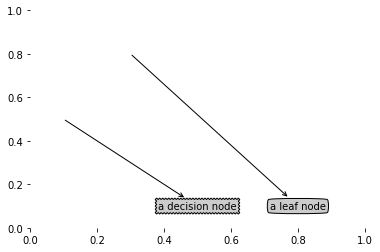

In [11]:
#使用文本绘制树节点
import matplotlib.pyplot as plt
#定制文本框和箭头格式
decisionNode = dict(boxstyle = "sawtooth",fc="0.8")
leafNode = dict(boxstyle="round4",fc="0.8")
arrow_args = dict(arrowstyle="<-")

#绘制带箭头的注解
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def createPlot():
    fig = plt.figure(1,facecolor = 'white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111,frameon=False)
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()
createPlot()

2.6  构造注解树

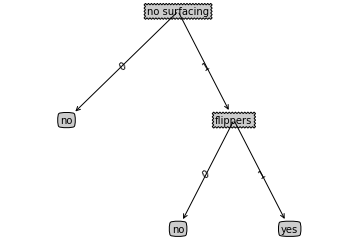

None
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


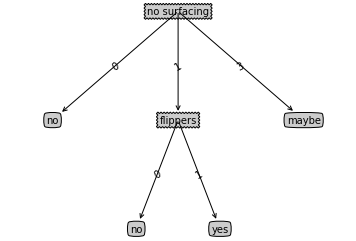

None
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}


In [12]:
#获取叶节点的数目和树的层数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1+getTreeDepth(secondDict[key])
        else:
            thisDepth=1
        if thisDepth>maxDepth:
            maxDepth = thisDepth
    return maxDepth

def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]
#print(retrieveTree(0))
#myTree = retrieveTree(0)
#print(getNumLeafs(myTree))
#print(getTreeDepth(myTree))


def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)
    
def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree)[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            plotTree(secondDict[key], cntrPt, str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

#if you do get a dictonary you know it's a tree, and the first element will be another dict



def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()
    
    
myTree = retrieveTree(0)
print(createPlot(myTree))
print(myTree)
myTree['no surfacing'][3]='maybe'
print(createPlot(myTree))
print(myTree)

2.7 测试和存储分类器

2.7.1 使用决策树的分类函数

In [13]:
def classify(inputTree,featLabels,testVec):
    firstStr = list(inputTree)[0]
    secondict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondict[key]
    if isinstance(valueOfFeat,dict):
        classLabel = classify(valueOfFeat,featLabels,testVec)
    else:
        classLabel = valueOfFeat
    return classLabel

In [14]:
myDat,labels = createDataSet()
print(labels)
myTree = retrieveTree(0)
print(myTree)
print(classify(myTree,labels,[1,0]))
print(classify(myTree,labels,[1,1]))

['no surfacing', 'flippers']
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
no
yes


2.7.2 决策树的存储

    由于每次使用决策树分类时都要重新构造决策树，而决策树的构造非常费时，所有这个为了省时，把决策树构造好之后存储起来

In [15]:
def storeTree(inputTree,filename):
    import pickle
    fw = open(filename,'wb')
    pickle.dump(inputTree,fw)
    fw.close()
def grabTree(filename):
    import pickle
    fr = open(filename,'rb')
    return pickle.load(fr)

In [16]:
storeTree(myTree,'D:\AGAME\MachineLearning\machinelearninginaction\Ch03/classifierStorage.txt')
grabTree('D:\AGAME\MachineLearning\machinelearninginaction\Ch03/classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

2.8 使用决策树预测隐形眼镜的类型

{'tearRate': {'normal': {'astigamatic': {'yes': {'prescript': {'hyper': {'age': {'young': 'hard', 'presbyopic': 'no lenses', 'pre': 'no lenses'}}, 'myope': 'hard'}}, 'no': {'age': {'young': 'soft', 'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}, 'pre': 'soft'}}}}, 'reduced': 'no lenses'}}


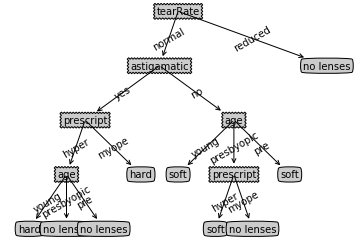

In [17]:
#创建树
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    #类别完全相同则停止继续划分
    if classList.count(classList[0])==len(classList):
        return classList[0]
    #遍历完所有特征时返回出现次数最多的
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    #得到列表包含的所有属性值
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels)
    return myTree
fr = open('D:\AGAME\MachineLearning\machinelearninginaction\Ch03/lenses.txt')
#解析tab键分隔的数据行
lenses=[inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age','prescript','astigamatic','tearRate']
lensesTree = createTree(lenses,lensesLabels)
print(lensesTree)
createPlot(lensesTree)